In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
from __init__ import list_rois, extract_samples, make_table, load_fit, get_waic_and_loo, get_waic, get_fit_path, get_model_path
warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
fits_path = './fits'
models_path = '.'
model_name = 'reducedlinearmodelq0'
fit_format = 1
params = ['R0', 'car', 'ifr']
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

In [4]:
model_path = get_model_path(models_path, model_name)
extension = ['csv', 'pkl'][fit_format]
rois = list_rois(fits_path, model_name, extension)
print("There are %d ROIs" % len(rois))

There are 3 ROIs


In [20]:
dfs = []

for roi in tqdm(rois):
    fit_path = get_fit_path(fits_path, model_name, roi)
    if fit_format==1:
        fit = load_fit(fit_path, model_path)
        stats = get_waic_and_loo(fit)
        #print(stats)
        samples = fit.to_dataframe()
    elif fit_format==0:
        samples = extract_samples(fits_path, models_path, model_name, roi, fit_format)
        stats = get_waic(samples)
    df = make_table(roi, samples, params, stats, quantiles=quantiles)
    dfs.append(df)

df = pd.concat(dfs)
df.to_csv('fit_table.csv')

100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


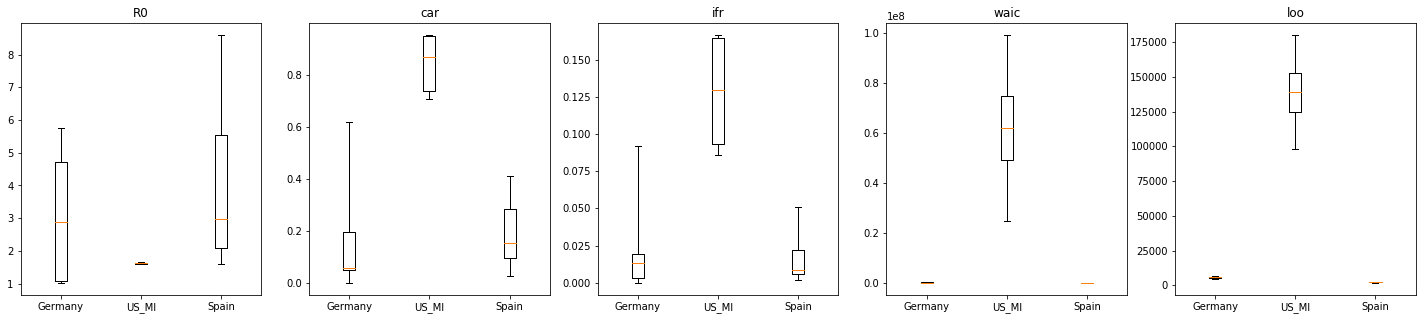

In [21]:
# The ROIs you want to plot
roi_subset = ['Germany', 'US_MI', 'Spain']

def plot_table_data(df, roi_subset):
    n_params = df.shape[1]
    fig, axes = plt.subplots(1, n_params, figsize=(n_params*5, 5))
    for i, ax in enumerate(axes.flat):
        for j, roi in enumerate(roi_subset):
            col = df.columns[i]
            boxes = [
                {
                'x': i,
                'label' : roi,
                'whislo': df.loc[(roi, np.min(quantiles)), col],    # Bottom whisker position
                'q1'    : df.loc[(roi, 0.25), col],    # First quartile (25th percentile)
                'med'   : df.loc[(roi, 0.5), col],    # Median         (50th percentile)
                'q3'    : df.loc[(roi, 0.75), col],    # Third quartile (75th percentile)
                'whishi': df.loc[(roi, np.max(quantiles)), col],    # Top whisker position
                'fliers': []        # Outliers
                }
            ]
            ax.bxp(boxes, positions=[j], showfliers=False)
        ax.set_title(df.columns[i])
        
plot_table_data(df, roi_subset)
plt.savefig('plot_table.png')